In [ ]:
import os

import json
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import pandas as pd
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras import layers, Model

#import boto3

from io import StringIO
#import chardet
from io import BytesIO


En el siguiente dataframe se tiene la información de cada publicación realizada, las variables que son de interes para realizar la clasificación son:
- NOMBRE: identificador de la imagen de la publicación
- AREA: Etiqueta que define si es una publicacion de marca o de fotografia 

In [2]:
df = pd.read_excel('BD_Instagram2.xlsx', engine='openpyxl') 
df.head(5)

,FOTO,NOMBRE,CAL.,CATEGORÍA,ÁREA,TIPO2,FECHA,IMPRESSIONS,REACH,LIKES,SAVED,COMMENTS,SHARED,EXPLORAR,SEGUIMIENTOS,VIDEO VIEWS (ORGANIC),ID,URL IG
0,IG-Nov-S4-2021-33,IG-Nov-S4-2021-33,A,Texto,Marca,IMAGEN,2021-11-22,672762,623476,39198,0,185,1971.0,NaN,NaN,0.0,NaN,NaN
1,IG-Nov-S4-2021-29,IG-Nov-S4-2021-29,A,Ilustración,Marca,CARRUSEL,2021-11-22,495307,440008,29930,0,79,1330.0,NaN,NaN,0.0,NaN,NaN
2,IG-Nov-S4-2021-32,IG-Nov-S4-2021-32,A,Mujer Piso,Fotografía,IMAGEN,2021-11-22,358652,344779,7431,0,211,216.0,NaN,NaN,0.0,NaN,NaN
3,IG-Nov-S4-2021-30,IG-Nov-S4-2021-30,AAA,Hombre Piso,Fotografía,CARRUSEL,2021-11-22,259247,220245,5639,0,50,203.0,NaN,NaN,0.0,NaN,NaN
4,IG-Nov-S4-2021-31,IG-Nov-S4-2021-31,A,Mujer Modelo,Fotografía,CARRUSEL,2021-11-22,245717,206797,6700,0,44,70.0,NaN,NaN,0.0,NaN,NaN


In [3]:
print("Numero de columnas:", df.shape[1])
print("Numero de registros:", df.shape[0])

Numero de columnas: 18
Numero de registros: 5194


**Consulta de la imagen de la publicación:**

Se leen las imagenes que se encuentran en formato tipo .jpg y se guargan en un dataframe, el cual tendra las siguientes columnas:
- NOMBRE: identificador de la imagen de la publicacion
- IMAGEN: URL de la imagen 

In [4]:
carpeta_imagenes = r"K:\Marca\Mercadeo\Marketing Digital\Doc. General Analítica\1. Herramientas\Fotos Informes" 
imagenes = [f for f in os.listdir(carpeta_imagenes) if f.lower().endswith('.jpg') and 'ig' in f.lower()] 
rutas_completas = [os.path.join(carpeta_imagenes, img) for img in imagenes]
nombres = [os.path.splitext(img)[0] for img in imagenes]

df_imagen = pd.DataFrame({
    'NOMBRE': nombres,
    'IMAGEN': rutas_completas
})
df_imagen.head(5)

,NOMBRE,IMAGEN
0,IG-Abr-S1-2022-01,K:\Marca\Mercadeo\Marketing Digital\Doc. Gener...
1,IG-Abr-S1-2022-02,K:\Marca\Mercadeo\Marketing Digital\Doc. Gener...
2,IG-Abr-S1-2022-03,K:\Marca\Mercadeo\Marketing Digital\Doc. Gener...
3,IG-Abr-S1-2022-04,K:\Marca\Mercadeo\Marketing Digital\Doc. Gener...
4,IG-Abr-S1-2022-05,K:\Marca\Mercadeo\Marketing Digital\Doc. Gener...


### Procesamiento inicial de las fuentes de datos

**Procesamiento del dataframe para obtener solo las variables de interes y estandarizadas:**

In [5]:
df_label = df[['NOMBRE', 'ÁREA']]

df_label.columns = df_label.columns.str.strip()
def quitar_tildes(serie):
    return serie.str.replace('á', 'a').str.replace('é', 'e').str.replace('í', 'i')\
                .str.replace('ó', 'o').str.replace('ú', 'u').str.replace('Á', 'A')\
                .str.replace('É', 'E').str.replace('Í', 'I').str.replace('Ó', 'O')\
                .str.replace('Ú', 'U')

df_label['ÁREA'] = quitar_tildes(df_label['ÁREA'])
df_label.head(5)

C:\Users\lriverosq\AppData\Local\Temp\ipykernel_28828\3964857921.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label['ÁREA'] = quitar_tildes(df_label['ÁREA'])


,NOMBRE,ÁREA
0,IG-Nov-S4-2021-33,Marca
1,IG-Nov-S4-2021-29,Marca
2,IG-Nov-S4-2021-32,Fotografia
3,IG-Nov-S4-2021-30,Fotografia
4,IG-Nov-S4-2021-31,Fotografia


**Procesamiento de las imagenes:**

In [6]:
def convertir_a_jpeg(ruta):
    try:
        with Image.open(ruta) as img:
            base = os.path.splitext(ruta)[0]
            nueva_ruta = base + ".jpg"
            
            img.convert('RGB').save(nueva_ruta, 'JPEG')
            return nueva_ruta
    except Exception as e:
        print(f"Error al convertir {ruta}: {e}")
        return None
    
df_imagen['IMAGEN'] = df_imagen['IMAGEN'].apply(lambda x: convertir_a_jpeg(x) if x.endswith('.tif') else x)

Se hace una union de los dos dataframe para tener relacionadas cada imagen con su etiqueta:

In [7]:
df_imagen = pd.merge(df_imagen, df_label,on = "NOMBRE" )
df_imagen.head(5)

,NOMBRE,IMAGEN,ÁREA
0,IG-Abr-S1-2022-01,K:\Marca\Mercadeo\Marketing Digital\Doc. Gener...,Fotografia
1,IG-Abr-S1-2022-02,K:\Marca\Mercadeo\Marketing Digital\Doc. Gener...,Marca
2,IG-Abr-S1-2022-03,K:\Marca\Mercadeo\Marketing Digital\Doc. Gener...,Fotografia
3,IG-Abr-S1-2022-04,K:\Marca\Mercadeo\Marketing Digital\Doc. Gener...,Marca
4,IG-Abr-S1-2022-05,K:\Marca\Mercadeo\Marketing Digital\Doc. Gener...,Fotografia


### Entendimiento y limpieza de los datos ###

**Tamaño del dataframe y cantidad de valores nulos:**

Se toman publicaciones desde noviembre del 2021 hasta mayo del 2025

In [8]:
print("Tamaño del dataframe con las imagenes:", len(df_imagen.index)) 
print("Valores nulos en la ruta de la imagen:", df_imagen['IMAGEN'].isnull().sum())

Tamaño del dataframe con las imagenes: 5056
Valores nulos en la ruta de la imagen: 0


¿Cuales son las etiquetas en las que se clasifica una publicación y cuantas publicaciones hay asociadas a esta etiqueta?

In [9]:
print("etiquetas:", df_imagen['ÁREA'].unique()) 
print("Etiqueta:", df_imagen['ÁREA'].value_counts())


etiquetas: ['Fotografia' 'Marca' 'Comercial' 'Hibrido' 'mARCA' 'Colaboracion']
Etiqueta: ÁREA
Fotografia      3411
Marca           1319
Comercial        279
Hibrido           44
Colaboracion       2
mARCA              1
Name: count, dtype: int64


**Limpieza de las etiquetas:**

Se oberva qe las etiquetas Fotografia y Marca son las mas predominantes, por lo que se dejan solo las publicacion con este tipo de etiquetas, ademas que por conocimiento del negocio se sabe que son las mas relevantes y las que influyen en toma de decisiones:

In [10]:
df_imagen['ÁREA'] = df_imagen['ÁREA'].str.replace('mARCA','Marca')
df_imagen = df_imagen[(df_imagen['ÁREA'] == 'Fotografia') | (df_imagen['ÁREA'] == 'Marca')]
print("etiquetas:", df_imagen['ÁREA'].unique())

etiquetas: ['Fotografia' 'Marca']


**Balanceo en las etiquetas:**

            CANTIDAD  PORCENTAJE
ÁREA                            
Fotografia      3411   72.098922
Marca           1320   27.901078


C:\Users\lriverosq\AppData\Local\Temp\ipykernel_28828\181351378.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_label.index, y=conteo_label['PORCENTAJE'], palette="viridis")


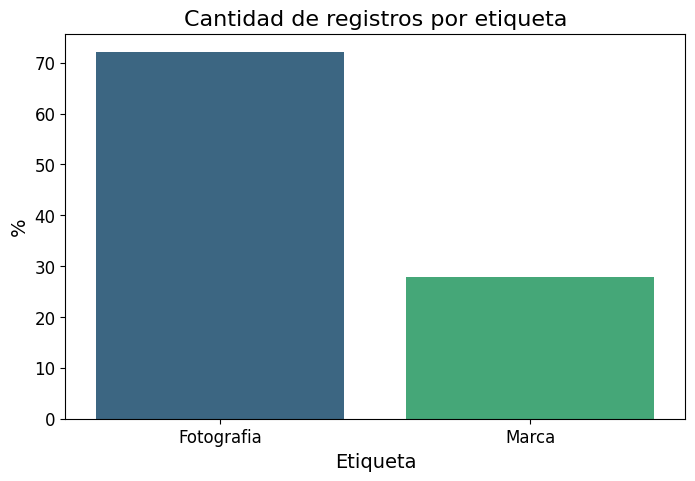

In [11]:
conteo_label = df_imagen['ÁREA'].value_counts().to_frame(name='CANTIDAD')
conteo_label['PORCENTAJE'] = df_imagen['ÁREA'].value_counts(normalize=True) * 100
print(conteo_label)

plt.figure(figsize=(8, 5))
sns.barplot(x=conteo_label.index, y=conteo_label['PORCENTAJE'], palette="viridis")
plt.title('Cantidad de registros por etiqueta', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Limpieza y transformación de las imagenes:**

In [12]:
def cargar_y_preprocesar_imagen(ruta_local):
    try:
        imagen_binaria = tf.io.read_file(ruta_local)
        imagen = tf.image.decode_image(imagen_binaria, channels=3)
        imagen = tf.image.resize(imagen, [100, 100])
        imagen = tf.cast(imagen, tf.float32) / 255.0
        return imagen
    except Exception as e:
        print(f"Error cargando {ruta_local}: {e}")
        return None


df_imagen['IMAGEN_COD'] = df_imagen['IMAGEN'].apply(cargar_y_preprocesar_imagen)

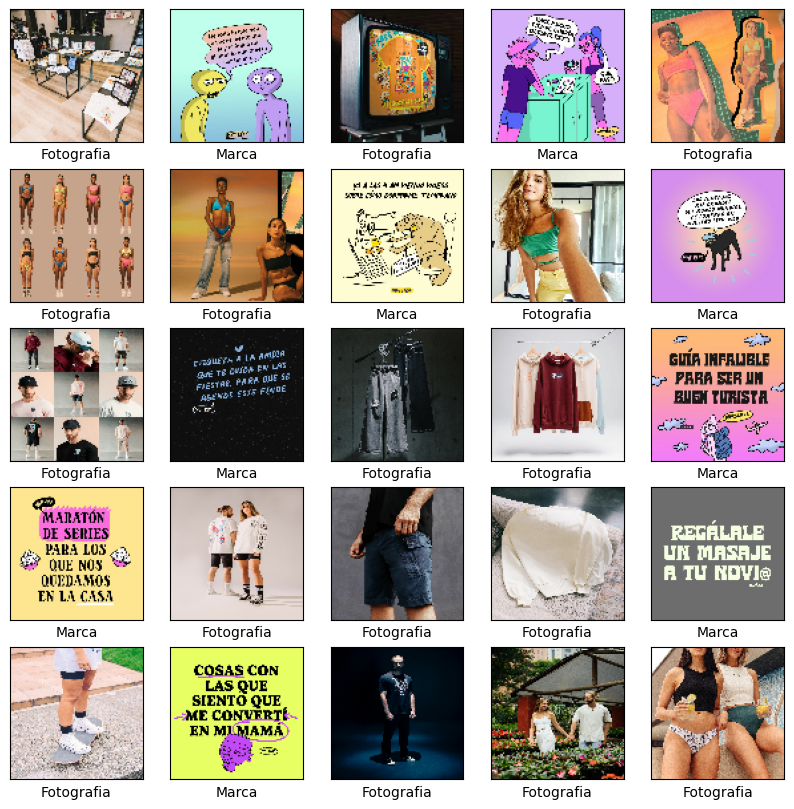

In [13]:
plt.figure(figsize=(10, 10))

for i, (idx, row) in enumerate(df_imagen.head(25).iterrows()): 
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(row['IMAGEN_COD'], cmap=plt.cm.binary)
    plt.xlabel(row['ÁREA'])

plt.show()

### Modelación

**Procesamiento de la data para modelar**:

Separación del dataset en entrenamiento y test (70% train - 30% test)

In [14]:
X = df_imagen['IMAGEN_COD']
Y = df_imagen['ÁREA']                           

X_train, X_vald, y_train, y_vald = train_test_split(X, Y, test_size=0.3, random_state=42)

print("Tamaño dataset entrenamiento:", len(y_train))
print("Tamaño dataset validación:", len(y_vald))

# Se convierten las etiquetas categóricas en salidas de 1 y 0
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_vald = label_encoder.fit_transform(y_vald)

# Convertir a One-Hot Encoding
#y_train = to_categorical(y_train)
#y_vald = to_categorical(y_vald)

# Convertimos los datos de la variable independiente en array
X_train_arrays = np.stack([x.numpy() for x in X_train])
X_vald_arrays = np.stack([x.numpy() for x in X_vald])


Tamaño dataset entrenamiento: 3311
Tamaño dataset validación: 1420


Se crea el Data generator

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=40,        
    width_shift_range=0.2,   
    height_shift_range=0.2, 
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,    
    fill_mode='nearest')

val_datagen = ImageDataGenerator()

In [16]:
train_generator = train_datagen.flow(X_train_arrays,
    y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(X_vald_arrays,
    y_vald,
    batch_size=32,
    shuffle=True
)

**Modelo Xception con Transfer Learning:**

In [17]:
class TLXceptionImNet(Model):
    def __init__(self, input_shape):
        super(TLXceptionImNet, self).__init__()
        
        self.base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=input_shape) #pesos preentrenados de ImageNet.
        
        self.global_avg_pooling = layers.GlobalAveragePooling2D() #capa global pooling
        self.dense = layers.Dense(1, activation='sigmoid') #capa densa

    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.global_avg_pooling(x)
        return self.dense(x)

input_shape = (100, 100, 3)
model = TLXceptionImNet(input_shape)

# Set the base_model layers to non-trainable
for layer in model.base_model.layers:
    layer.trainable = False

In [18]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

history_model = model.fit(train_generator,
                    epochs = 100, 
                    batch_size=32,
                    validation_data= val_generator)  

c:\Users\lriverosq\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 347ms/step - accuracy: 0.8354 - loss: 0.3779 - val_accuracy: 0.9380 - val_loss: 0.1982
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 33s 313ms/step - accuracy: 0.9320 - loss: 0.2059 - val_accuracy: 0.9479 - val_loss: 0.1712
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 32s 307ms/step - accuracy: 0.9448 - loss: 0.1740 - val_accuracy: 0.9451 - val_loss: 0.1690
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 297ms/step - accuracy: 0.9454 - loss: 0.1649 - val_accuracy: 0.9486 - val_loss: 0.1736
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 30s 291ms/step - accuracy: 0.9472 - loss: 0.1529 - val_accuracy: 0.9514 - val_loss: 0.1597
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - accuracy: 0.9599 - loss: 0.1264 - val_accuracy: 0.9486 - val_loss: 0.1620
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 298ms/step - accuracy: 0.9498 - loss: 0.1524 - val_accuracy: 0.9507 - val_loss: 0.1623
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 30s 290ms/step - accuracy: 0.9582 -

**Modelo MobileNetV2:**

In [25]:
def build_mobilenetv2_binary(input_shape=(100, 100, 3)):
    base = MobileNetV2(input_shape=input_shape,include_top=False,weights='imagenet')
    base.trainable = False 

    inputs = layers.Input(shape=input_shape)

    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x) 
    
    outputs = layers.Dense(1, activation='sigmoid')(x)  
    model = Model(inputs, outputs)
    return model

model_mobileNet = build_mobilenetv2_binary()

C:\Users\lriverosq\AppData\Local\Temp\ipykernel_28828\3913728196.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(input_shape=input_shape,include_top=False,weights='imagenet')


In [26]:
model_mobileNet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_mobileNet = model_mobileNet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100
)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.8180 - loss: 0.4630 - val_accuracy: 0.9141 - val_loss: 0.2365
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 348ms/step - accuracy: 0.9176 - loss: 0.2174 - val_accuracy: 0.9218 - val_loss: 0.2192
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 341ms/step - accuracy: 0.9228 - loss: 0.2077 - val_accuracy: 0.9352 - val_loss: 0.1922
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9329 - loss: 0.1906 - val_accuracy: 0.9373 - val_loss: 0.1954
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9357 - loss: 0.2019 - val_accuracy: 0.9345 - val_loss: 0.1865
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9459 - loss: 0.1706 - val_accuracy: 0.9423 - val_loss: 0.1787
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9463 - loss: 0.1625 - val_accuracy: 0.9394 - val_loss: 0.1777
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9482 - loss: 0.1

**Modelo ResNET50:**

In [19]:
def build_resnet50_binary(input_shape=(100, 100, 3)):
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    base_model.trainable = False  
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Crear modelo
model_resnet50 = build_resnet50_binary()

In [20]:
model_resnet50.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_resnet50 = model_resnet50.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100
)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 287ms/step - accuracy: 0.6964 - loss: 0.6175 - val_accuracy: 0.7021 - val_loss: 0.5783
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - accuracy: 0.7193 - loss: 0.5735 - val_accuracy: 0.7542 - val_loss: 0.5402
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - accuracy: 0.7519 - loss: 0.5502 - val_accuracy: 0.7268 - val_loss: 0.5137
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step - accuracy: 0.7638 - loss: 0.5139 - val_accuracy: 0.7479 - val_loss: 0.4899
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 271ms/step - accuracy: 0.7536 - loss: 0.5190 - val_accuracy: 0.7599 - val_loss: 0.4769
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - accuracy: 0.7620 - loss: 0.4982 - val_accuracy: 0.7746 - val_loss: 0.4614
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 274ms/step - accuracy: 0.7721 - loss: 0.4911 - val_accuracy: 0.7915 - val_loss: 0.4494
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 279ms/step - accuracy: 0.7754 -

In [21]:
def build_resnet50_binary(input_shape=(100, 100, 3)):
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    base_model.trainable = False  
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Crear modelo
model_resnet50_2 = build_resnet50_binary()

In [22]:
model_resnet50_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_resnet50_2 = model_resnet50_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100
)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 296ms/step - accuracy: 0.6666 - loss: 0.6642 - val_accuracy: 0.7085 - val_loss: 0.5615
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 283ms/step - accuracy: 0.7312 - loss: 0.5786 - val_accuracy: 0.7387 - val_loss: 0.5355
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 30s 286ms/step - accuracy: 0.7450 - loss: 0.5486 - val_accuracy: 0.7634 - val_loss: 0.5145
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 30s 290ms/step - accuracy: 0.7543 - loss: 0.5292 - val_accuracy: 0.7789 - val_loss: 0.5020
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.7588 - loss: 0.5164 - val_accuracy: 0.7585 - val_loss: 0.4851
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 32s 309ms/step - accuracy: 0.7683 - loss: 0.4984 - val_accuracy: 0.7754 - val_loss: 0.4725
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 299ms/step - accuracy: 0.7639 - loss: 0.5082 - val_accuracy: 0.7761 - val_loss: 0.4639
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 299ms/step - accuracy: 0.7802 -

### Evaluación del modelo 

**Perdida y exactitud:**

In [27]:
loss_model1, accuracy_model1 = model.evaluate(X_vald_arrays, y_vald)
loss_model2, accuracy_model2 = model_mobileNet.evaluate(X_vald_arrays, y_vald)
loss_model3, accuracy_model3 = model_resnet50.evaluate(X_vald_arrays, y_vald)
loss_model4, accuracy_model4 = model_resnet50_2.evaluate(X_vald_arrays, y_vald)


print(f"Modelo 1: Loss={loss_model1}, Accuracy={accuracy_model1}")
print(f"Modelo 2: Loss={loss_model2}, Accuracy={accuracy_model2}")
print(f"Modelo 3: Loss={loss_model3}, Accuracy={accuracy_model3}")
print(f"Modelo 4: Loss={loss_model4}, Accuracy={accuracy_model4}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.9559 - loss: 0.1553
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9527 - loss: 0.1487
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.8698 - loss: 0.3343
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.8653 - loss: 0.3365
Modelo 1: Loss=0.15774695575237274, Accuracy=0.9549295902252197
Modelo 2: Loss=0.17231401801109314, Accuracy=0.9492957592010498
Modelo 3: Loss=0.35879600048065186, Accuracy=0.8542253375053406
Modelo 4: Loss=0.3571188151836395, Accuracy=0.858450710773468


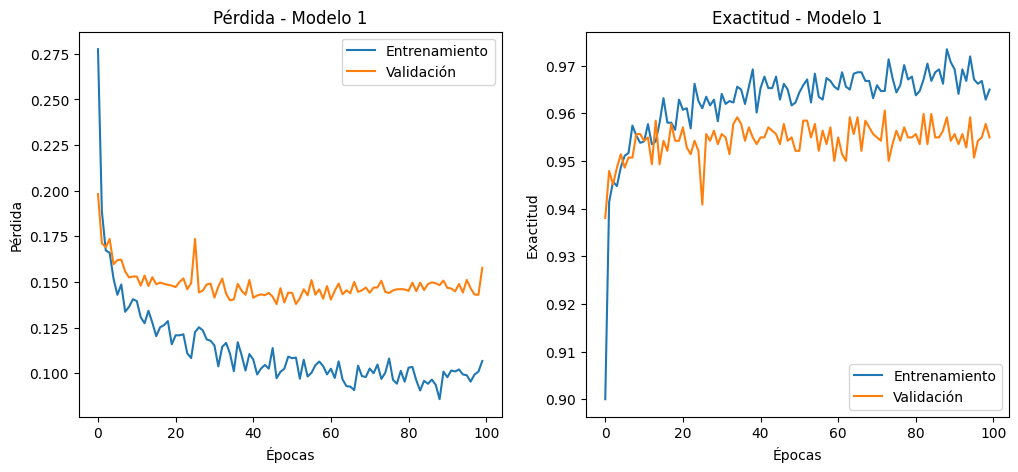

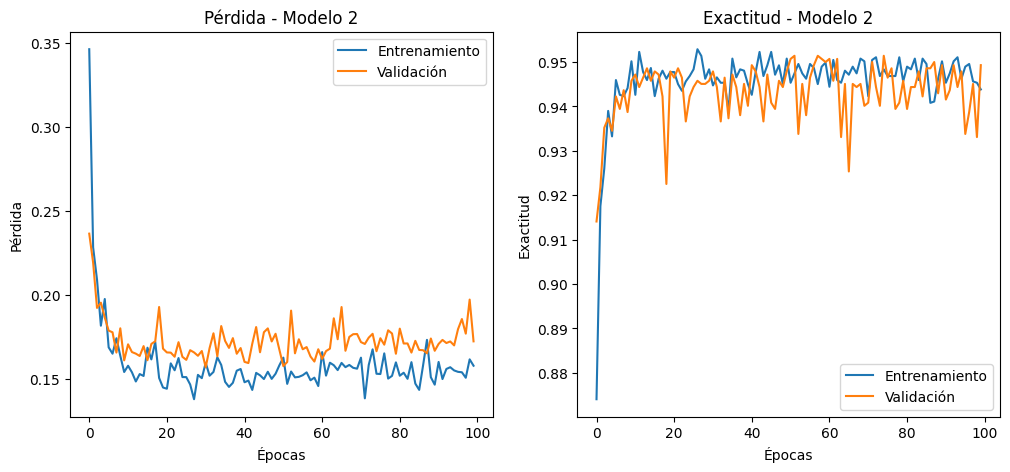

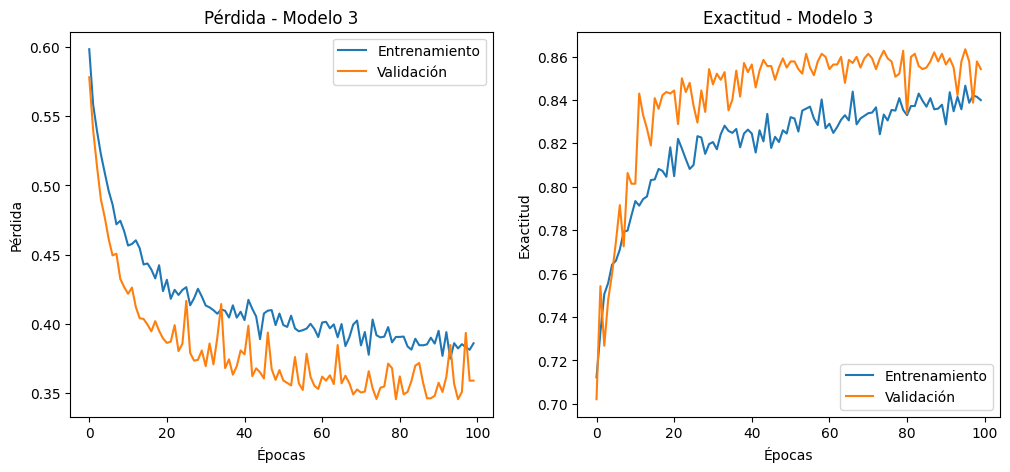

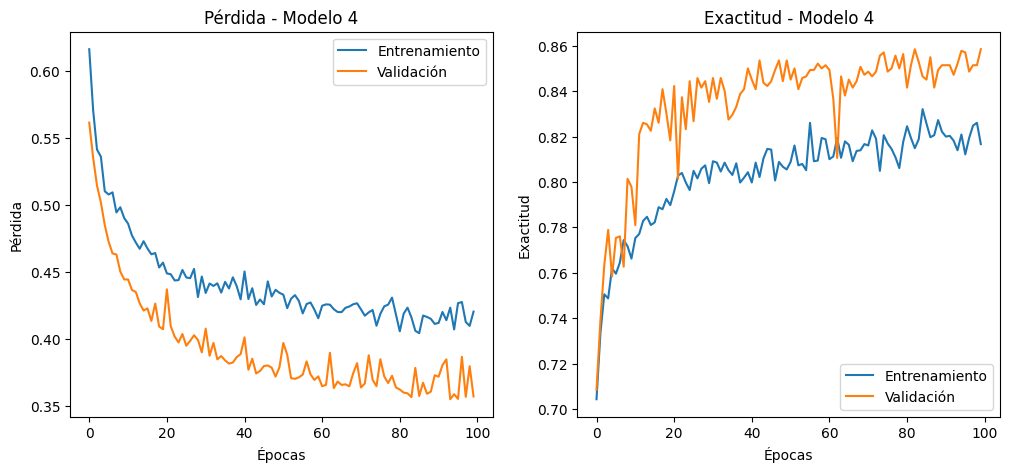

In [29]:
def plot_history(history, title="Modelo"):
    plt.figure(figsize=(12, 5))
    
    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Pérdida - {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Exactitud
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title(f'Exactitud - {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Exactitud')
    plt.legend()
    plt.show()

# Graficar para cada modelo
plot_history(history_model, "Modelo 1")
plot_history(history_mobileNet, "Modelo 2")
plot_history(history_resnet50, "Modelo 3")
plot_history(history_resnet50_2, "Modelo 4")

**Curva ROC y AUC (Area bajo la curva):**

In [30]:
y_score1 = model.predict(X_vald_arrays).ravel()           # Xception
y_score2 = model_mobileNet.predict(X_vald_arrays).ravel() # MobileNet
y_score3 = model_resnet50.predict(X_vald_arrays).ravel()  # ResNet50
y_score4 = model_resnet50_2.predict(X_vald_arrays).ravel()# ResNet50_2


y_true = y_vald        


fpr1, tpr1, _ = roc_curve(y_true, y_score1)
fpr2, tpr2, _ = roc_curve(y_true, y_score2)
fpr3, tpr3, _ = roc_curve(y_true, y_score3)
fpr4, tpr4, _ = roc_curve(y_true, y_score4)

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)
auc4 = auc(fpr4, tpr4)

45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step


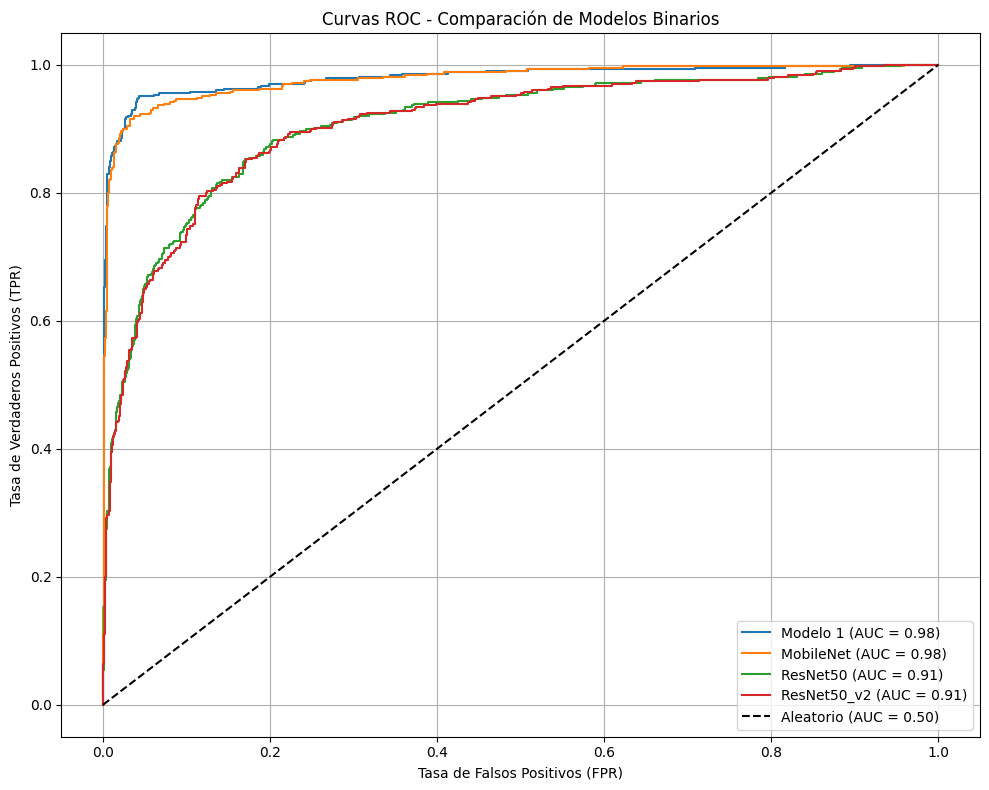

In [31]:
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, label=f"Modelo 1 (AUC = {auc1:.2f})")
plt.plot(fpr2, tpr2, label=f"MobileNet (AUC = {auc2:.2f})")
plt.plot(fpr3, tpr3, label=f"ResNet50 (AUC = {auc3:.2f})")
plt.plot(fpr4, tpr4, label=f"ResNet50_v2 (AUC = {auc4:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Aleatorio (AUC = 0.50)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC - Comparación de Modelos Binarios")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
modelos = {
    "Modelo 1": model,
    "MobileNet": model_mobileNet,
    "ResNet50": model_resnet50,
    "ResNet50_v2": model_resnet50_2
}

y_real = y_vald

resultados = []

for nombre, modelo in modelos.items():
    y_prob = modelo.predict(X_vald_arrays).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_prob)
    })


metricas = pd.DataFrame(resultados)
metricas = metricas.sort_values(by="F1 Score", ascending=False)
metricas.reset_index(drop=True, inplace=True)


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step


## Guardar Modelo ##

Se guardan los pesos del modelo que mejor se entreno:

In [33]:
model.save("modelo_clasificación_img.keras")